In [1]:
import numpy as np
import pandas as pd
import os
import glob
import itertools
import scanpy as sc
import natsort
import json

from scroutines import basicu

In [2]:
%%time
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/superdupermegaRNA_hasraw.h5ad'
adata_all = sc.read(f, backed='r')
genes_mul = adata_all.var.index.values.astype(str) 
genes_mul, genes_mul.shape

CPU times: user 388 ms, sys: 900 ms, total: 1.29 s
Wall time: 2.06 s


(array(['Xkr4', 'Gm1992', 'Rp1', ..., 'Tmlhe', 'AC149090.1',
        'CAAA01118383.1'], dtype='<U14'),
 (16572,))

In [3]:
%%time
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/reorganized/all_L23_pcs_allsamples_250114.h5ad'
adata_l23 = sc.read(f)
adata_l23


CPU times: user 322 ms, sys: 3.18 s, total: 3.5 s
Wall time: 41.8 s


AnnData object with n_obs × n_vars = 41048 × 7720
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond', 'easitype'
    obsm: 'pcs_p28on', 'pcs_p8'
    layers: 'lognorm', 'norm', 'zlognorm'

In [4]:
ddir = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized'

In [5]:
unq_conds = [os.path.basename(f)[:-len('.h5ad')] for f in natsort.natsorted(glob.glob(ddir+'/*.h5ad'))]
nf = len(unq_conds)
unq_conds, nf

(['P8NR',
  'P14NR',
  'P17NR',
  'P21NR',
  'P28DL',
  'P28DR',
  'P28NR',
  'P38DR',
  'P38NR'],
 9)

In [6]:
### check size
for i, f in enumerate(natsort.natsorted(glob.glob(ddir+'/*.h5ad'))):
    print(f)
    cond_name = os.path.basename(f)[:-len('.h5ad')]

    adata = sc.read(f, backed='r')
    adata.obs['biosample'] = adata.obs['sample'].apply(lambda x: x[:-1])
    
    adata_l23_sub = adata_l23[adata_l23.obs['cond']==cond_name]
    
    # check cells
    cells_overlap = np.intersect1d(adata_l23_sub.obs.index.values, adata.obs.index.values)
    assert len(cells_overlap) ==  adata_l23_sub.shape[0]
    
    # check gene 
    adata = adata[adata_l23_sub.obs.index, genes_mul]
    print(adata.shape)
    
    # # check gene 
    # if i == 0:
    #     genes = adata.var.index.values
    # else:
    #     assert np.all(genes == adata.var.index.values)
        
    # # check type
    # if i == 0:
    #     type_lbls = adata.obs['Subclass'].values
    #     unq_types = np.unique(type_lbls)
    # else:
    #     assert np.all(unq_types == np.unique(adata.obs['Subclass'].values))
        
    # check sample
    sample_lbls = adata.obs['biosample'].values
    unq_samples = np.unique(sample_lbls)

    # check size
    nr, ng =  len(unq_samples), len(adata.var)  #  rep, subclass, gene 
    print(nr, ng)
    

/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P8NR.h5ad
(3383, 16572)
2 16572
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P14NR.h5ad
(6247, 16572)
2 16572
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P17NR.h5ad
(5684, 16572)
2 16572
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P21NR.h5ad
(4465, 16572)
2 16572
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P28DL.h5ad
(4659, 16572)
2 16572
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P28DR.h5ad
(4704, 16572)
2 16572
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P28NR.h5ad
(4044, 16572)
2 16572
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P38DR.h5ad
(5165, 16572)
2 16572
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P38NR.h5ad
(2697, 16572)
2

In [7]:
nc = 5
nf, nr, nc, ng

(9, 2, 5, 16572)

In [8]:
### read in the file and prep

bigtensor = np.zeros((nf, nr, nc, ng))

for i, f in enumerate(natsort.natsorted(glob.glob(ddir+'/*.h5ad'))):
    print(f)
    cond_name = os.path.basename(f)[:-len('.h5ad')]

    adata = sc.read(f)
    adata.obs['biosample'] = adata.obs['sample'].apply(lambda x: x[:-1])
    
    # check cells
    adata_l23_sub = adata_l23[adata_l23.obs['cond']==cond_name]
    cells_overlap = np.intersect1d(adata_l23_sub.obs.index.values, adata.obs.index.values)
    assert len(cells_overlap) ==  adata_l23_sub.shape[0]
    
    # check cells and genes
    adata = adata[adata_l23_sub.obs.index, genes_mul]
    adata.obsm['pcs_p28on'] = adata_l23_sub.obsm['pcs_p28on']
    print(adata.shape)
    
    ### sum over counts 
    # by sample
    sample_lbls = adata.obs['biosample'].values
    unq_samples = np.unique(sample_lbls)

    # by type -- cut into nc=5 equal bins
    x = adata.obsm['pcs_p28on'][...,0]
    type_lbls = pd.qcut(x, nc, labels=np.arange(nc)).astype(int)
    unq_types = np.unique(type_lbls)

    nr, nc, ng =  len(unq_samples), len(unq_types), len(adata.var)  #  rep, subclass, gene 

    for j, this_samp in enumerate(unq_samples):
        for k, this_type in enumerate(unq_types):
            selector = ((sample_lbls==this_samp) & (type_lbls==this_type))
            bigtensor[i,j,k] = np.sum(np.array(adata[selector].X.todense()), axis=0) # raw reads sum over all cells
            
### CPM  - per cond, sample and subclass
# normalize it as log2(1+CPM)
bigtensor = (bigtensor/np.sum(bigtensor, axis=-1, keepdims=True))*1e6
bigtensor = np.log2(1+bigtensor) 

/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P8NR.h5ad
(3383, 16572)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P14NR.h5ad
(6247, 16572)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P17NR.h5ad
(5684, 16572)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P21NR.h5ad
(4465, 16572)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P28DL.h5ad
(4659, 16572)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P28DR.h5ad
(4704, 16572)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P28NR.h5ad
(4044, 16572)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P38DR.h5ad
(5165, 16572)
/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/organized/P38NR.h5ad
(2697, 16572)


In [9]:
output = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/bigtensor_l23type.npy' 
np.save(output, bigtensor)

In [10]:
output_meta = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/bigtensor_l23type.json' 
meta = {
    'size': bigtensor.shape,
    
    'dim0': list(unq_conds),
    'dim1': ['a', 'b'],
    'dim2': ['A', 'AB', 'B', 'BC', 'C'], #list(unq_types.astype(str)),
    'dim3': list(genes_mul),
}

with open(output_meta, 'w') as fp:
    json.dump(meta, fp)

In [11]:
bigtensor = np.load(output)
bigtensor.shape

(9, 2, 5, 16572)

In [12]:
with open(output_meta, 'r') as fp:
    meta = json.load(fp)

# plot

In [13]:
import matplotlib.pyplot as plt
from scroutines.config_plots import *

In [14]:
class Bigtensor():
    def __init__(self, bigtensor, meta):
        
        self.palette = {
            'NR': 'C1', 
            'DR': 'k',
            'DL': 'C2', 
        }

        self.anno_marker_dict = {
            'NR': 'o',
            'DR': 's',
            'DL': '^',
        }
        
        self.bigtensor = bigtensor
        self.nf, self.nr, self.nc, self.ng = meta['size']
        self.conds = np.array(meta['dim0'])
        self.reps  = np.array(meta['dim1'])
        self.types = np.array(meta['dim2'])
        self.genes = np.array(meta['dim3'])

        self.conds_time = np.array([int(cond[1:-2]) for cond in self.conds])
        self.conds_anno = np.array([cond[-2:] for cond in self.conds])
        self.conds_color = pd.Series(self.palette).loc[self.conds_anno].values 
        
        return
    
    def plot_one(self, ax, selected_type, selected_gene, annotate=True):
        """
        """
        type_idx = basicu.get_index_from_array(self.types, [selected_type])[0]
        gene_idx = basicu.get_index_from_array(self.genes, [selected_gene])[0]
        
        assert np.all(type_idx != -1)
        assert np.all(gene_idx != -1)

        vals = self.bigtensor[:,:,type_idx, gene_idx] # cond by rep
        vals_mean = np.mean(vals, axis=1)


        ax.set_title(f'{selected_gene} in {selected_type}')
        for anno in ['NR', 'DR', 'DL']:
            marker = self.anno_marker_dict[anno]
            sel = self.conds_anno == anno
            if anno == 'NR':
                ax.set_xticks(self.conds_time[sel])
                ax.plot(self.conds_time[sel], vals_mean[sel], '-k')
                
            ax.scatter(np.repeat(self.conds_time[sel], self.nr), vals[sel].reshape(-1,), 
                       color='k',
                       facecolors='none',
                       marker=marker,
                       label=anno,
                      )

        sns.despine(ax=ax)
        ax.grid(axis='x')

        if annotate:
            handles, labels = ax.get_legend_handles_labels()
            unique_labels = dict(zip(labels, handles))
            ax.legend(unique_labels.values(), unique_labels.keys(), fontsize=12) # , bbox_to_anchor=(1,1))

            ax.set_xlabel('Postnatal day (P)')
            ax.set_ylabel('log2(CPM+1)')
        

In [15]:
bo = Bigtensor(bigtensor, meta)

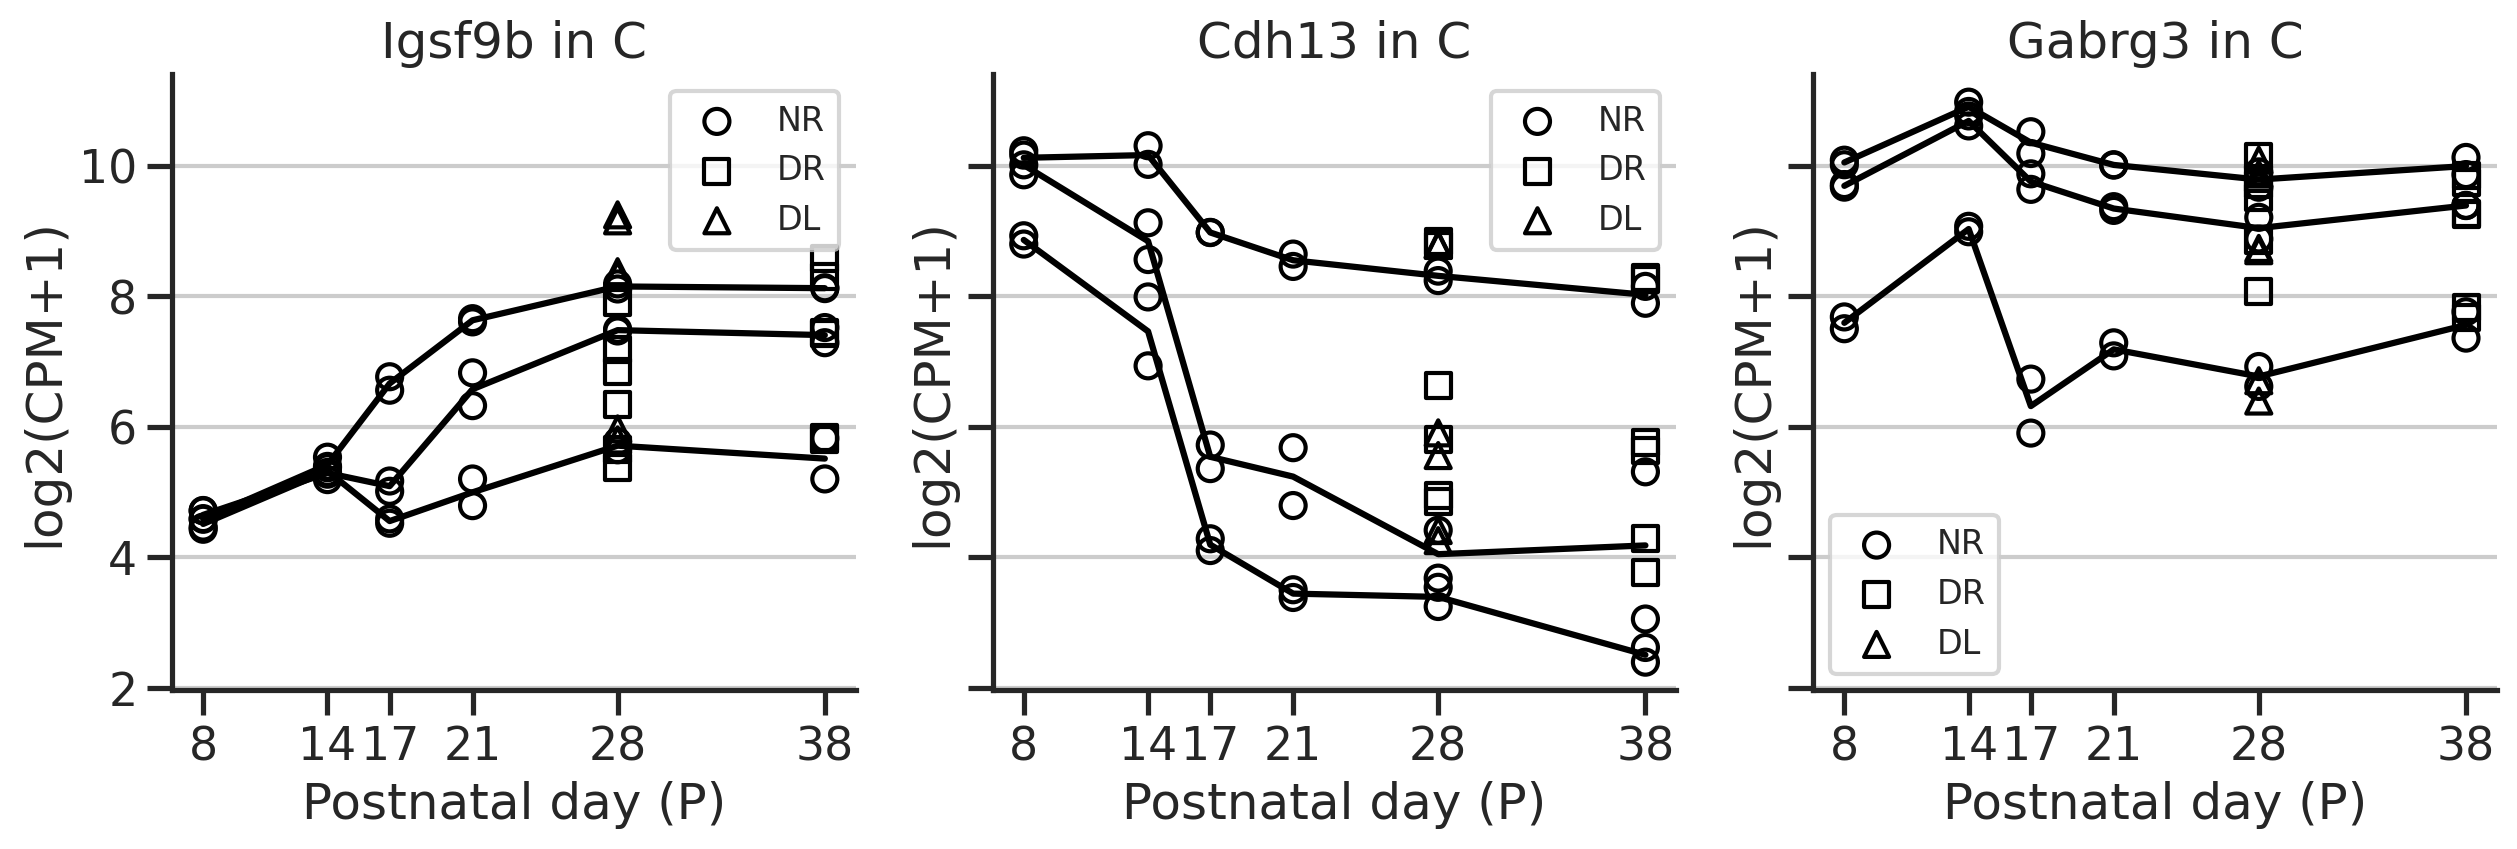

In [16]:
fig, axs = plt.subplots(1,3,figsize=(3*5,1*4), sharex=True, sharey=True)
ax = axs[0]
bo.plot_one(ax, 'A', 'Igsf9b')
bo.plot_one(ax, 'B', 'Igsf9b', annotate=False)
bo.plot_one(ax, 'C', 'Igsf9b', annotate=False)
ax = axs[1]
bo.plot_one(ax, 'A', 'Cdh13')
bo.plot_one(ax, 'B', 'Cdh13', annotate=False)
bo.plot_one(ax, 'C', 'Cdh13', annotate=False)
ax = axs[2]
bo.plot_one(ax, 'A', 'Gabrg3')
bo.plot_one(ax, 'B', 'Gabrg3', annotate=False)
bo.plot_one(ax, 'C', 'Gabrg3', annotate=False)